   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

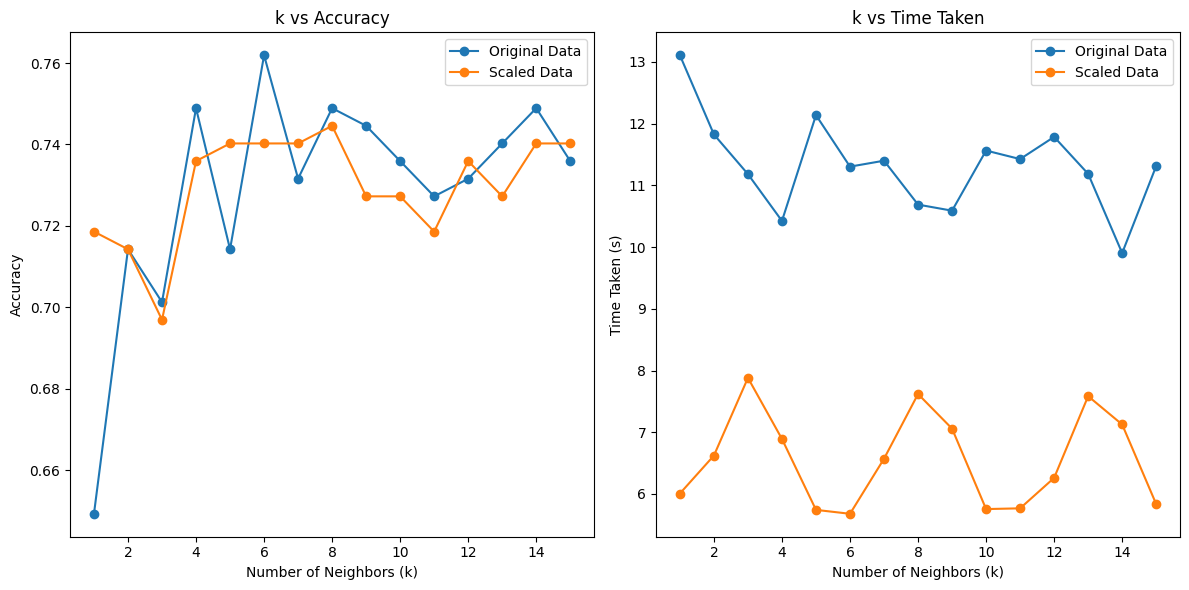

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Copy of diabetes.csv')

# Exploratory Data Analysis (EDA)
print(df.head())
print(df.info())
print(df.describe())
print("Missing Values:\n", df.isnull().sum())

def handle_missing_data(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in [np.float64, np.int64]:
                # Impute numeric columns with their median
                df[col].fillna(df[col].median(), inplace=True)
            else:
                # Impute categorical columns with their mode
                df[col].fillna(df[col].mode()[0], inplace=True)
    print("\nMissing values after handling:")
    print(df.isnull().sum())
    return df

# Separate Features (X) and Target (y)
X = df.drop(columns=['Outcome'])  # Assuming 'Outcome' is the target column
y = df['Outcome']

np.random.seed(42)
indices = np.random.permutation(len(X))
split_idx = int(0.7 * len(X))
train_idx, test_idx = indices[:split_idx], indices[split_idx:]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Function to calculate Euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Function to predict the class for a single query
def predict_single(X_train, y_train, query, k=3):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train.iloc[i].values, query)
        distances.append((dist, y_train.iloc[i]))
    distances.sort(key=lambda x: x[0])
    nearest_neighbors = distances[:k]
    classes = [neighbor[1] for neighbor in nearest_neighbors]
    return max(set(classes), key=classes.count)

# Function to predict classes for all test samples
def predict(X_train, y_train, X_test, k=3):
    predictions = []
    for i in range(len(X_test)):
        pred = predict_single(X_train, y_train, X_test.iloc[i].values, k)
        predictions.append(pred)
    return predictions

# Evaluate accuracy
def accuracy(y_true, y_pred):
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

# KNN Model on original data
k = 3
y_pred = predict(X_train, y_train, X_test, k)
acc_original = accuracy(y_test, y_pred)
print(f"Accuracy on original data with k={k}: {acc_original}")

# Scale the feature matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled = X_scaled[train_idx], X_scaled[test_idx]

# KNN on scaled data
y_pred_scaled = predict(pd.DataFrame(X_train_scaled), y_train, pd.DataFrame(X_test_scaled), k)
acc_scaled = accuracy(y_test, y_pred_scaled)
print(f"Accuracy on scaled data with k={k}: {acc_scaled}")

# Experimentation with varying k
k_values = range(1, 16)
accuracies_original = []
accuracies_scaled = []
times_original = []
times_scaled = []

for k in k_values:
    # Original data
    start_time = time.time()
    y_pred = predict(X_train, y_train, X_test, k)
    end_time = time.time()
    accuracies_original.append(accuracy(y_test, y_pred))
    times_original.append(end_time - start_time)

    # Scaled data
    start_time = time.time()
    y_pred_scaled = predict(pd.DataFrame(X_train_scaled), y_train, pd.DataFrame(X_test_scaled), k)
    end_time = time.time()
    accuracies_scaled.append(accuracy(y_test, y_pred_scaled))
    times_scaled.append(end_time - start_time)

# Visualization
plt.figure(figsize=(12, 6))

# Plot k vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies_original, label='Original Data', marker='o')
plt.plot(k_values, accuracies_scaled, label='Scaled Data', marker='o')
plt.title('k vs Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()

# Plot k vs Time Taken
plt.subplot(1, 2, 2)
plt.plot(k_values, times_original, label='Original Data', marker='o')
plt.plot(k_values, times_scaled, label='Scaled Data', marker='o')
plt.title('k vs Time Taken')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Time Taken (s)')
plt.legend()

plt.tight_layout()
plt.show()
